# Imports

In [1]:
import chess
import numpy as np
import tensorflow as tf
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
import random
import keras
from keras.layers import Input
import pandas as pd

# Displaying Chess Board

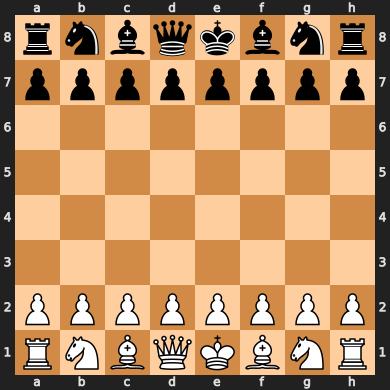

In [2]:
board = chess.Board()
board

# Converting chess board to input

In [3]:
def board_to_input(board):
    # Define a mapping for pieces to integers
    piece_to_value = {
        (chess.PAWN, chess.WHITE): 1,
        (chess.KNIGHT, chess.WHITE): 2,
        (chess.BISHOP, chess.WHITE): 3,
        (chess.ROOK, chess.WHITE): 4,
        (chess.QUEEN, chess.WHITE): 5,
        (chess.KING, chess.WHITE): 6,
        (chess.PAWN, chess.BLACK): 7,
        (chess.KNIGHT, chess.BLACK): 8,
        (chess.BISHOP, chess.BLACK): 9,
        (chess.ROOK, chess.BLACK): 10,
        (chess.QUEEN, chess.BLACK): 11,
        (chess.KING, chess.BLACK): 12
    }

    # 8x8 grid with 17 channels: 12 for pieces, 4 for castling rights, 1 for side to move
    board_representation = np.zeros((8, 8, 17), dtype=int)
    
    # Fill the board representation with values for each piece using concept of one hot encoding
    for square in chess.SQUARES:
        rank = chess.square_rank(square)
        file = chess.square_file(square)
        piece = board.piece_at(square)
        if piece is not None:
            value = piece_to_value.get((piece.piece_type, piece.color))
            board_representation[rank, file, value - 1] = 1

    # Castling rights and side to move
    castling_rights_white_kingside = int(board.has_kingside_castling_rights(chess.WHITE))
    castling_rights_white_queenside = int(board.has_queenside_castling_rights(chess.WHITE))
    castling_rights_black_kingside = int(board.has_kingside_castling_rights(chess.BLACK))
    castling_rights_black_queenside = int(board.has_queenside_castling_rights(chess.BLACK))
    side_to_move = int(board.turn == chess.WHITE)

    # Add castling rights and side to move to the last two channels uniformly
    board_representation[:, :, 12] = castling_rights_white_kingside
    board_representation[:, :, 13] = castling_rights_white_queenside
    board_representation[:, :, 14] = castling_rights_black_kingside
    board_representation[:, :, 15] += castling_rights_black_queenside
    board_representation[:, :, 16] = side_to_move

    return board_representation

# Saving the game data:
 ##   1. Saving the game statistics as a whole
 ##  2. Saving datas for the final position of the checkmate

In [4]:
def save_game_stats_to_csv(game_data, file_name):
    df = pd.DataFrame(game_data)
    df.to_csv(f'{file_name}.csv', index=False)

In [5]:
def save_game_data_to_csv(game_data, file_name):
    processed_data = []

    for item in game_data:
        processed_item = []
        for element in item:
            # Check if the element is a numpy array or similar structure
            if isinstance(element, (np.ndarray, list)):
                # Convert the array to a string representation
                string_repr = np.array2string(element, separator=',', threshold=np.inf)
                processed_item.append(string_repr)
            else:
                processed_item.append(element)
        processed_data.append(processed_item)

    # Convert the processed data to a DataFrame
    df = pd.DataFrame(processed_data)

    # Save the DataFrame to a CSV file
    df.to_csv(f'{file_name}.csv', index=False)

# Counting total pieceses of the board for both side

In [6]:
def count_pieces(board):
    piece_count = {'WHITE': 0, 'BLACK': 0}
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            if piece.color == chess.WHITE:
                piece_count['WHITE'] += 1
            else:
                piece_count['BLACK'] += 1
    return piece_count

# Main Method

In [7]:
def main():
    num_games = 200000         # Total number of self play games
    batch_games = 200000        # Batchsize to decide to save the number of games in regular interval
    game_statistics = []       # List that contains the whole game statiscts i.e. Result, Total Remaining pieces, Total move
    game_count = 0             # Total game played so far
    accumulated_game_data = []       # List of all the game datas (i.e. board positions and resutls) played for num_games
    for game in range(num_games + 1):
        board = chess.Board()            # Instance of board
        
        game_data = []                   # Current game data (board positions and results, result will be filled at the end of game)
        temp_game_data = []              # Temp game data required for saving
        move_count = 0                   # Total move occured in a game
        while not board.is_game_over():            # Playing until game is over
            legal_moves = list(board.legal_moves)  # List of all the legal moves in that position
            board_input = board_to_input(board)    # converting the board_position to board_input vector
            best_move = random.choice(legal_moves) # Choosing random move from all the legal move available
            final_reward = 0                       # Reward for the final result of the game. Currently set to 0.
            
            temp_game_data.append((board_input, '*', final_reward))  # Storing the board position
            # Make the move
            board.push(best_move)
            move_count = move_count + 1
            
        final_reward = 1 if board.result() == '1-0' else -1 if board.result() == '0-1' else 0   # Assigning reward as per the result
        
        board_input = board_to_input(board)
        if final_reward == 1 or final_reward == -1:                   # For storing the data only if there is win or loss
            random_choice = random.randint(0, len(temp_game_data)-1)  # Randomly selecting position other than checkmate
            game_data.append(temp_game_data[random_choice])           # Storing that randomly selected position to store some non-checkmate position
            game_data.append((board_input, '*', final_reward))        # Sotring the checkmate position
            
        piece_count = count_pieces(board)
        result = board.result()
        game_statistics.append({
        'game_number': game_count,
        'total_moves': move_count,
        'remaining_pieces': piece_count,
        'result': result
        })
        
        for state, action, final_reward in game_data:
            accumulated_game_data.append((state, action, final_reward))

        game_count = game_count + 1

        if game_count % batch_games == 0:
            save_game_stats_to_csv(game_statistics, f'1-model_{game_count}_game_stat')
            save_game_data_to_csv(accumulated_game_data, f'1-{game_count}_game')
        if game_count % 1000 == 0:
            print("Game finished: ", game_count)
if __name__ == "__main__":
    main()

Game finished:  1000
Game finished:  2000
Game finished:  3000
Game finished:  4000
Game finished:  5000
Game finished:  6000
Game finished:  7000
Game finished:  8000
Game finished:  9000
Game finished:  10000
Game finished:  11000
Game finished:  12000
Game finished:  13000
Game finished:  14000
Game finished:  15000
Game finished:  16000
Game finished:  17000
Game finished:  18000
Game finished:  19000
Game finished:  20000
Game finished:  21000
Game finished:  22000
Game finished:  23000
Game finished:  24000
Game finished:  25000
Game finished:  26000
Game finished:  27000
Game finished:  28000
Game finished:  29000
Game finished:  30000
Game finished:  31000
Game finished:  32000
Game finished:  33000
Game finished:  34000
Game finished:  35000
Game finished:  36000
Game finished:  37000
Game finished:  38000
Game finished:  39000
Game finished:  40000
Game finished:  41000
Game finished:  42000
Game finished:  43000
Game finished:  44000
Game finished:  45000
Game finished:  460